In [1]:
import os
import matplotlib.pyplot as plt
import h5py
import phase_contrast as pc
from pathlib import Path
import numpy as np
from PIL import Image
from file_paths import get_path

In [2]:
from scipy.interpolate import interp1d
from helper import crop

from scipy.ndimage import zoom
from scipy.ndimage.morphology import binary_closing, binary_fill_holes, binary_dilation, distance_transform_edt
from skimage.morphology import disk
from skimage import measure
import scipy.ndimage as ndimage
from skimage.segmentation import flood_fill

In [3]:
from skimage.morphology import extrema

In [4]:
SCRIPT_PATH = os.getcwd()
PHANTOM_DB_FOLDER_NAME = 'database'
TXT_FOULDER_NAME = 'txt_files'
FILE_ID = '123495'
TXT_FILE_NAME = f'diamond {FILE_ID}.txt'

In [5]:
def get_img(file_name):
    file_path = os.path.join(SCRIPT_PATH, PHANTOM_DB_FOLDER_NAME, file_name)

    with h5py.File(file_path, 'r') as hdf:
        dataset = hdf.get(name = file_name)
        dataset = dataset[()]
    return dataset

In [ ]:
def binary_fill_boarders(img, value=0, width=5, orientation='v'):
    if orientation =='v':
        if value == 0:
            mask = np.zeros(img.shape, dtype=int)
            mask[:, width:-width] = 1
            return img * mask
        elif value == 1:
            mask = np.ones(img.shape, dtype=int)
            mask[:, width:-width] = 0
            return img + mask
        else:
            raise ValueError("only values 0 and 1 are accepted")
    elif orientation =='h':
        if value == 0:
            mask = np.zeros(img.shape, dtype=int)
            mask[width:-width, :] = 1
            return img * mask
        elif value == 1:
            mask = np.ones(img.shape, dtype=int)
            mask[width:-width, :] = 0
            return img + mask
        else:
            raise ValueError("only values 0 and 1 are accepted")

In [6]:
def get_2d_slice(num, file_id=FILE_ID):
    data_folder = get_path(file_id)

    file_names = Path(data_folder).glob('*.tiff')
    file_names = list(file_names)
    img2d_gray = img2d = np.array(Image.open(file_names[num]))

    return img2d_gray

In [7]:
def write_dict_to_file(dict):
    for key, value in dict.items():
        write_item_to_file(key, value)


def write_item_to_file(key, value):
    db_folder = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME)
    if not os.path.isdir(db_folder):
        os.mkdir(db_folder)

    file_path = os.path.join(SCRIPT_PATH, TXT_FOULDER_NAME, TXT_FILE_NAME)
    file_txt = open(file_path,"a")
    file_txt.write(f"{key} {value} \n")
    file_txt.close()


In [8]:
k_dictionary ={}

In [9]:
a = np.asarray([-3, -4, -1, 2, 3, 2, 1, 5, -5, 1])
np.argmax(np.abs(np.diff(a > 0)))

2

In [12]:
def binary_fill_boarders(img, value=0, width=5, orientation='v'):
    if orientation =='v':
        if value == 0:
            mask = np.zeros(img.shape, dtype=int)
            mask[:, width:-width] = 1
            return img * mask
        elif value == 1:
            mask = np.ones(img.shape, dtype=int)
            mask[:, width:-width] = 0
            return img + mask
        else:
            raise ValueError("only values 0 and 1 are accepted")
    elif orientation =='h':
        if value == 0:
            mask = np.zeros(img.shape, dtype=int)
            mask[width:-width, :] = 1
            return img * mask
        elif value == 1:
            mask = np.ones(img.shape, dtype=int)
            mask[width:-width, :] = 0
            return img + mask
        else:
            raise ValueError("only values 0 and 1 are accepted")

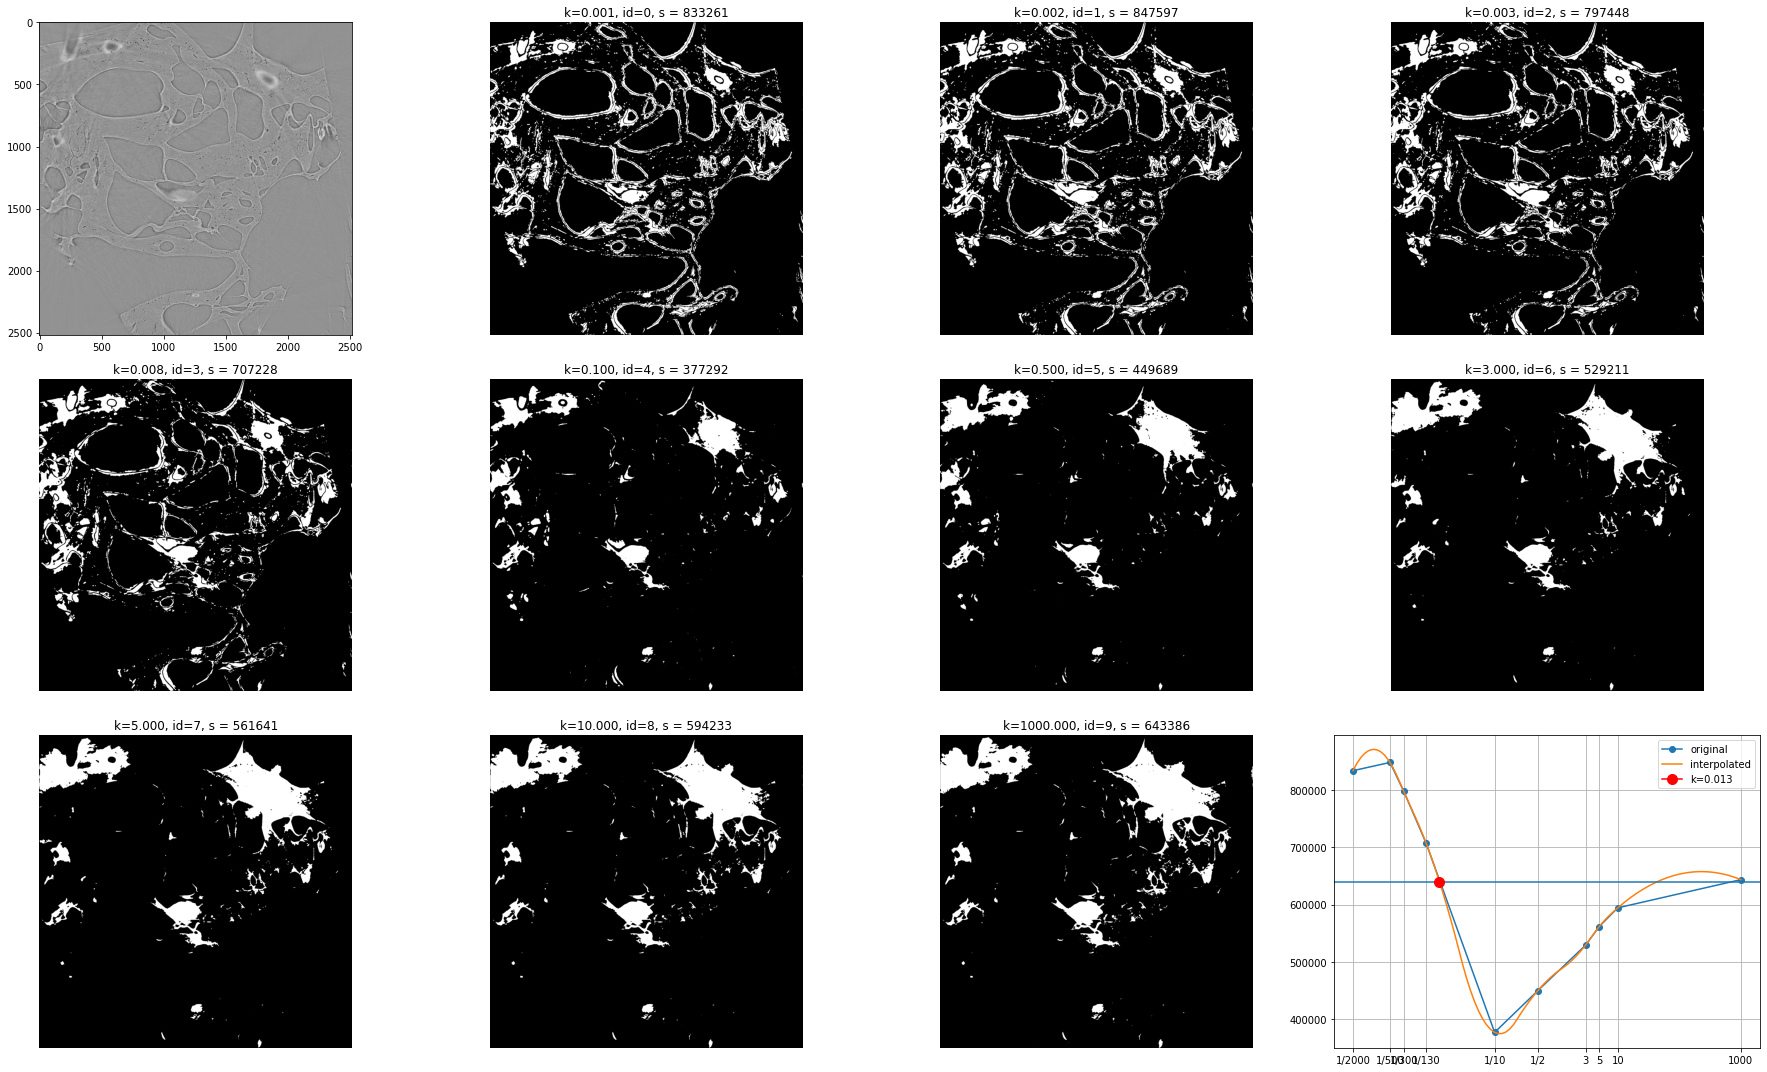

In [11]:
#k_possible_values = [1/10, 1/20, 1/80, 1/100, 1/130, 1/500, 1/300]
k_possible_values = [1/2000, 1/500, 1/300, 1/130, 1/10, 1/2, 3, 5, 10, 1000]
slice_num = 874
k = k_possible_values[0]

img2d_gray = get_2d_slice(slice_num, '123495')
fig, axes = plt.subplots(3, 4, figsize=(25,15))

axes = axes.ravel()
axes[0].imshow(img2d_gray, cmap='gray')

squares = []
for i, k in enumerate(k_possible_values):
    bin_img = pc.binarize_slice(img2d_gray, k=k, mu=25e-8)
    square = np.sum(bin_img)
    squares.append(square)
    axes[i+1].imshow(bin_img, cmap='gray')
    axes[i+1].set_title(f"k={k:.3f}, id={i}, s = {square}")
    axes[i+1].axis("off")

x_log = np.log(k_possible_values)

f2 = interp1d(x_log, squares, kind='quadratic')
axes[-1].plot(x_log, squares, '-o', label='original')
x_new = np.linspace(np.min(x_log), np.max(x_log), num=100, endpoint=True)
y_new = f2(x_new)
axes[-1].plot(x_new, y_new, '-', label='interpolated')
y_horizental_line = np.percentile(y_new, 55)

indx = np.argmax(np.abs(np.diff((y_new - y_horizental_line) > 0)))
x_intersection_point = x_new[indx]
k_calculated = np.exp(x_intersection_point)
axes[-1].axhline(y_horizental_line)
axes[-1].plot([x_intersection_point], [y_horizental_line], marker='o', markersize=10, color="red", label=f'k={k_calculated:.3f}')
x_ticks = ['1/2000', '1/500', '1/300', '1/130', '1/10', '1/2','3', '5', '10', '1000']
plt.xticks(np.log(k_possible_values), x_ticks)
axes[-1].grid()
axes[-1].legend()

plt.tight_layout()

In [ ]:

fig, axes = plt.subplots(figsize=(7, 7))
axes.imshow(pc.binarize_slice(img2d_gray, k=k_calculated, mu=25e-8), cmap='gray')


In [ ]:
#id = 7
#k_dictionary.update({f"{slice_num}": k_possible_values[id]})

k_dictionary.update({f"{slice_num}": k_calculated})

In [ ]:
k_dictionary

In [ ]:
k_dictionary = sorted(k_dictionary.items(), key=lambda item: item[0])
k_dictionary = dict(k_dictionary)

In [ ]:
#k_dictionary = {'750': 500, '780': 0.5, '810': 20, '840': 20, '870': 15}
k_dictionary

In [ ]:
# backup
write_dict_to_file(k_dictionary)
k_dictionary = {}

# _RESULTS_

In [ ]:
file_id='123497'
img3d = get_img(f'{file_id}.h5')

In [ ]:
# 787 = good example
num = np.random.randint(0,2120)

fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(img3d[num], cmap='gray')
axes[1].imshow(get_2d_slice(num, file_id), cmap='gray')

# for ax in axes:
#     ax.axis("off")
plt.tight_layout()
num

In [ ]:
img2d=img3d[num]

In [ ]:
def get_2d_mask_by_crop(img2d, margin):
    mask = np.ones(img2d.shape)
    return binary_fill_boarders(mask, value=0, width=margin, orientation='h')

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

axes[0].imshow(img2d, cmap='gray')

margin = 100
axes[0].axhline(margin, color="red", lw=5)
axes[0].axhline(img2d.shape[0]-margin, color="red", lw=5)
axes[1].imshow(get_2d_slice(num, file_id), cmap='gray')

axes[2].imshow(img2d*2+get_2d_mask_by_crop(img2d, margin=100), cmap='gray')
# for ax in axes:
#     ax.axis("off")
plt.tight_layout()